# Testing

### Imports

In [1]:
import os, math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

import mapping, generator
import utils
from settings import *

### Import models

Specify the path to the model files

In [2]:
MODEL_PATH = "./models/cats_128"

ma_mapping = mapping.build_model()
ma_generator = generator.build_model()

ma_mapping.load_weights(os.path.join(MODEL_PATH, "ma_mapping.h5"))
ma_generator.load_weights(os.path.join(MODEL_PATH, "ma_generator.h5"))

### Utils

In [3]:
def gen_z(nb):
	return np.random.normal(size = (nb, LATENT_DIM))

def gen_noise(nb):
	return [np.random.normal(0., 1., (nb, IMAGE_SIZE, IMAGE_SIZE, 1)) for _ in range((NB_BLOCKS * 2) - 1)]

def gen_w(z, batch_size = None):

	if batch_size is None:
		batch_size = z.shape[0]

	w = np.zeros((z.shape[0], LATENT_DIM), dtype = np.float32)

	for i in range(0, z.shape[0], batch_size):

		size = min(batch_size, z.shape[0] - i)
		w[i:i + size, :] = ma_mapping(tf.convert_to_tensor(z[i:i + size])).numpy()

	return w

def gen_images(w, noise, batch_size = None):

	if batch_size is None:
		batch_size = w.shape[0]

	generations = np.zeros((w.shape[0], IMAGE_SIZE, IMAGE_SIZE, NB_CHANNELS), dtype = np.uint8)

	for i in range(0, w.shape[0], batch_size):

		size = min(batch_size, w.shape[0] - i)
		const_input = [tf.ones((size, 1))]
		n = [tf.convert_to_tensor(j[i:i + size]) for j in noise]
		gen = ma_generator(const_input + ([w[i:i + size]] * NB_BLOCKS) + n)
		generations[i:i + size, :, :, :] = utils.denorm_img(gen.numpy())

	return generations

def plot(images, shape, path = None, show = True):

	output_image = np.full((
		MARGIN + (shape[1] * (images.shape[2] + MARGIN)),
		MARGIN + (shape[0] * (images.shape[1] + MARGIN)),
		images.shape[3]), 255, dtype = np.uint8)

	i = 0
	for row in range(shape[1]):
		for col in range(shape[0]):
			r = row * (images.shape[2] + MARGIN) + MARGIN
			c = col * (images.shape[1] + MARGIN) + MARGIN
			output_image[r:r + images.shape[2], c:c + images.shape[1]] = images[i]
			i += 1

	if show:
		dpi = mpl.rcParams['figure.dpi']
		fig = plt.figure(figsize = (output_image.shape[0] / float(dpi), output_image.shape[1] / float(dpi)), dpi = dpi)
		ax = fig.add_axes([0, 0, 1, 1])
		ax.axis('off')
		ax.imshow(output_image)
		plt.show()

	img = Image.fromarray(output_image)

	if path is not None:
		img.save(path)

### Mean W

Compute the mean W vector to generate troncated W vectors (increase quality)

In [4]:
z = gen_z(100000)
w = gen_w(z, batch_size = 1000)
mean_w = np.mean(w, axis = 0)

In [5]:
def gen_images_truncated(w, noise, psi = 1., batch_size = None):

	return gen_images(mean_w + psi * (w - mean_w), noise, batch_size = batch_size)

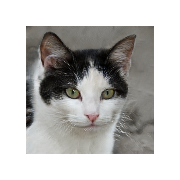

In [6]:
z = gen_z(1)
w = gen_w(z)
noise = gen_noise(1)
image = gen_images_truncated(w, noise, psi = 0.)

plot(image, (1, 1))

### Tests

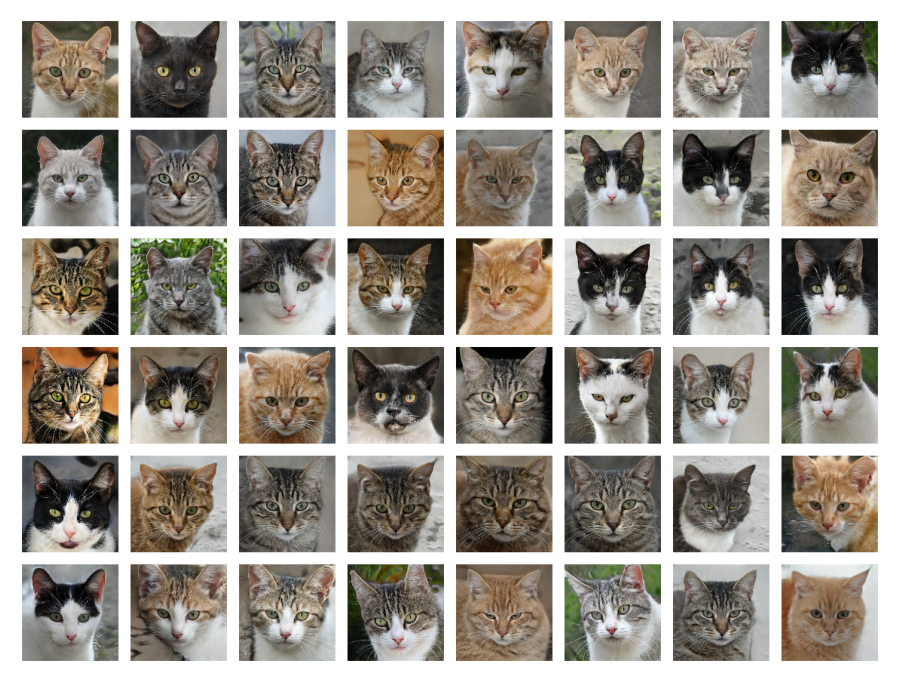

In [7]:
shape = (8, 6)
z = gen_z(shape[0] * shape[1])
w = gen_w(z)
noise = gen_noise(shape[0] * shape[1])
images = gen_images_truncated(w, noise, psi = 0.7)

plot(images, shape, "test.png")